In [1]:
import os
import json

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mtgc.ai.preprocessing import CardPreprocessor
from mtgc.ai.dataset import DraftDataset
from mtgc.ai.model import DraftPicker

# Prepare data

In [2]:
draft_data_dtypes_path = "../data/mkm/17lands/draft_data_public.MKM.PremierDraft.columns.json"
draft_data_path = "../data/mkm/17lands/draft_data_public.MKM.PremierDraft.csv"

In [3]:
with open(draft_data_dtypes_path, "r") as f:
    dtypes_dict = json.load(f)

draft_data_df = pd.read_csv(draft_data_path, nrows=100_000, dtype=dtypes_dict)

In [4]:
mkm_card_folder = "../data/mkm/cards"

In [5]:
cards_data_dict = {}

for filename in os.listdir(mkm_card_folder):
    file_path = os.path.join(mkm_card_folder, filename)
    card_name = filename.split(".")[0]
    
    with open(file_path, "r") as f:
        card_json_dict = json.load(f)

    cards_data_dict[card_name] = card_json_dict

In [6]:
# FIXME: Handle cases like 'Kellan, Inquisitive Prodigy // Tail the Suspect'
draft_data_df = draft_data_df[draft_data_df["pick"].isin(cards_data_dict)].reset_index(drop=True)

In [7]:
pack_columns = [column for column in draft_data_df.columns if "pack_card_" in column]
draft_data_df = draft_data_df[draft_data_df[pack_columns].sum(axis=1) > 1].reset_index(drop=True)

In [8]:
pool_columns = [column for column in draft_data_df.columns if "pool_" in column]
draft_data_df = draft_data_df[draft_data_df[pool_columns].sum(axis=1) > 0].reset_index(drop=True)

In [9]:
card_preprocessor = CardPreprocessor(
    card_type_vocabulary = [
        "Land",
        "Creature",
        "Artifact",
        "Enchantment",
        "Planeswalker",
        "Battle",
        "Instant",
        "Sorcery"
    ],
    keyword_vocabulary = [
        "Attach",
        "Counter",
        "Exile",
        "Fight",
        "Mill",
        "Sacrifice",
        "Scry",
        "Tap",
        "Untap",
        "Deathtouch",
        "Defender",
        "Double strike",
        "Enchant",
        "Equip",
        "First strike",
        "Flash",
        "Flying",
        "Haste",
        "Hexproof",
        "Indestructible",
        "Lifelink",
        "Menace",
        "Protection",
        "Prowess",
        "Reach",
        "Trample",
        "Vigilance"
    ]
)

In [10]:
draft_dataset = DraftDataset(
    draft_data_df=draft_data_df,
    cards_data_dict=cards_data_dict,
    card_preprocessor=card_preprocessor
)

In [11]:
training_draft_dataset, validation_draft_dataset = torch.utils.data.random_split(draft_dataset, [0.8, 0.2])

# Training

In [12]:
n_epochs = 20
n_cumulation_steps = 100
learning_rate = 1e-4

device = torch.device("cuda")

In [13]:
model = DraftPicker(
    input_dim=45,
    transformer_encoder_n_layers=10,
    transformer_encoder_layer_dim=128,
    transformer_encoder_layer_n_heads=8
).to(device)

/home/gcoter/projects/personal/magic-the-gathering-collection/venv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
model

DraftPicker(
  (input_mlp): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): ReLU()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_mlp): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [15]:
sum(p.numel() for p in model.parameters())

5936257

In [16]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [17]:
training_cumulated_loss = 0.0
n_steps_since_last_cumulation = 0
training_draft_dataset_indices = np.arange(len(training_draft_dataset))
loss_history = {"step": [], "training_loss": []}
model.train()

DraftPicker(
  (input_mlp): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): ReLU()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_mlp): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [18]:
for n in range(n_epochs):
    print(f"===== Epoch {n + 1}/{n_epochs} =====")
    np.random.shuffle(training_draft_dataset_indices)
    for i, training_draft_dataset_index in enumerate(training_draft_dataset_indices):
        x, y = training_draft_dataset[training_draft_dataset_index]
        x = x.to(device)
        y = y.to(device)
        y_logits = model(x)

        pack_card_mask = x[..., -1].bool()
        y = y[pack_card_mask]
        y_logits = y_logits[pack_card_mask]

        loss = torch.nn.functional.cross_entropy(y_logits, y)
        training_cumulated_loss += loss.cpu().detach().numpy()
        n_steps_since_last_cumulation += 1
        loss.backward()

        if (i > 0 and i % n_cumulation_steps == 0) or (i == len(training_draft_dataset_indices) - 1):
            training_cumulated_loss = training_cumulated_loss / n_steps_since_last_cumulation
            loss_history["step"].append(n * len(training_draft_dataset_indices) + i)
            loss_history["training_loss"].append(training_cumulated_loss)
            print(f"{i}/{len(training_draft_dataset)}: {training_cumulated_loss:.4f}")
            optimizer.step()
            optimizer.zero_grad()
            training_cumulated_loss = 0.0
            n_steps_since_last_cumulation = 0

===== Epoch 1/20 =====
100/69310: 1.3650
200/69310: 1.2541
300/69310: 1.3730
400/69310: 1.3092
500/69310: 1.5776
600/69310: 1.2520
700/69310: 1.2683
800/69310: 1.1824
900/69310: 1.3415
1000/69310: 1.1197
1100/69310: 1.2440
1200/69310: 1.3986
1300/69310: 1.3064
1400/69310: 1.4052
1500/69310: 1.3663
1600/69310: 1.2630
1700/69310: 1.2786
1800/69310: 1.5268
1900/69310: 1.3680
2000/69310: 1.2324
2100/69310: 1.3689
2200/69310: 1.3965
2300/69310: 1.4285
2400/69310: 1.4391
2500/69310: 1.3425
2600/69310: 1.0825
2700/69310: 1.3379
2800/69310: 1.2111
2900/69310: 1.3927
3000/69310: 1.2875
3100/69310: 1.2165
3200/69310: 1.3605
3300/69310: 1.4707
3400/69310: 1.2237
3500/69310: 1.4032
3600/69310: 1.3332
3700/69310: 1.4274
3800/69310: 1.3014
3900/69310: 1.2492
4000/69310: 1.2036
4100/69310: 1.3677
4200/69310: 1.1506
4300/69310: 1.3158
4400/69310: 1.3826
4500/69310: 1.2832
4600/69310: 1.6958
4700/69310: 1.5344
4800/69310: 1.3180
4900/69310: 1.3996
5000/69310: 1.5332
5100/69310: 1.2891
5200/69310: 1.148

KeyboardInterrupt: 

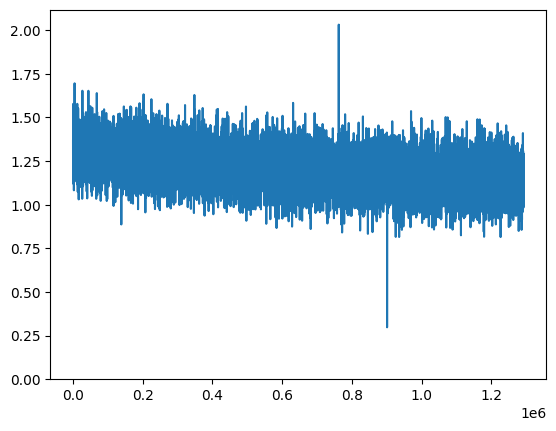

In [19]:
plt.plot(loss_history["step"], loss_history["training_loss"])
plt.ylim(bottom=0.0)
plt.show()

In [20]:
correct_count = 0
random_correct_count = 0
model.eval()

for i, (x, y) in enumerate(validation_draft_dataset):
    if i > 0 and i % 1000 == 0:
        print(f"{i}/{len(validation_draft_dataset)}")

    x = x.to(device)
    y = y.to(device)
    y_logits = model(x)

    pack_card_mask = x[..., -1].bool()
    y = y[pack_card_mask]
    y_logits = y_logits[pack_card_mask]

    if torch.argmax(y_logits) == torch.argmax(y):
        correct_count += 1

    if torch.randint(len(y), size=(1,))[0] == torch.argmax(y):
        random_correct_count += 1

accuracy = 100 * correct_count / len(validation_draft_dataset)
random_accuracy = 100 * random_correct_count / len(validation_draft_dataset)
print(f"Validation Accuracy: {accuracy:.1f}% (random: {random_accuracy:.1f}%)")

1000/17327
2000/17327
3000/17327
4000/17327
5000/17327
6000/17327
7000/17327
8000/17327
9000/17327
10000/17327
11000/17327
12000/17327
13000/17327
14000/17327
15000/17327
16000/17327
17000/17327
Validation Accuracy: 42.1% (random: 18.8%)


In [21]:
torch.save(model.state_dict(), "../models/draft_picker_mkm.pt")

In [22]:
model = DraftPicker(
    input_dim=45,
    transformer_encoder_n_layers=10,
    transformer_encoder_layer_dim=128,
    transformer_encoder_layer_n_heads=8
).to(device)
model.load_state_dict(torch.load("../models/draft_picker_mkm.pt"))
model.eval()

/home/gcoter/projects/personal/magic-the-gathering-collection/venv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


DraftPicker(
  (input_mlp): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): ReLU()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_mlp): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [23]:
correct_count = 0
random_correct_count = 0
model.eval()

for i, (x, y) in enumerate(validation_draft_dataset):
    if i > 0 and i % 1000 == 0:
        print(f"{i}/{len(validation_draft_dataset)}")

    x = x.to(device)
    y = y.to(device)
    y_logits = model(x)

    pack_card_mask = x[..., -1].bool()
    y = y[pack_card_mask]
    y_logits = y_logits[pack_card_mask]

    if torch.argmax(y_logits) == torch.argmax(y):
        correct_count += 1

    if torch.randint(len(y), size=(1,))[0] == torch.argmax(y):
        random_correct_count += 1

accuracy = 100 * correct_count / len(validation_draft_dataset)
random_accuracy = 100 * random_correct_count / len(validation_draft_dataset)
print(f"Validation Accuracy: {accuracy:.1f}% (random: {random_accuracy:.1f}%)")

1000/17327
2000/17327
3000/17327
4000/17327
5000/17327
6000/17327
7000/17327
8000/17327
9000/17327
10000/17327
11000/17327
12000/17327
13000/17327
14000/17327
15000/17327
16000/17327
17000/17327
Validation Accuracy: 42.1% (random: 18.7%)


In [24]:
for n in range(n_epochs):
    print(f"===== Epoch {n + 1}/{n_epochs} =====")
    np.random.shuffle(training_draft_dataset_indices)
    for i, training_draft_dataset_index in enumerate(training_draft_dataset_indices):
        x, y = training_draft_dataset[training_draft_dataset_index]
        x = x.to(device)
        y = y.to(device)
        y_logits = model(x)

        pack_card_mask = x[..., -1].bool()
        y = y[pack_card_mask]
        y_logits = y_logits[pack_card_mask]

        loss = torch.nn.functional.cross_entropy(y_logits, y)
        training_cumulated_loss += loss.cpu().detach().numpy()
        n_steps_since_last_cumulation += 1
        loss.backward()

        if (i > 0 and i % n_cumulation_steps == 0) or (i == len(training_draft_dataset_indices) - 1):
            training_cumulated_loss = training_cumulated_loss / n_steps_since_last_cumulation
            loss_history["step"].append(n * len(training_draft_dataset_indices) + i)
            loss_history["training_loss"].append(training_cumulated_loss)
            print(f"{i}/{len(training_draft_dataset)}: {training_cumulated_loss:.4f}")
            optimizer.step()
            optimizer.zero_grad()
            training_cumulated_loss = 0.0
            n_steps_since_last_cumulation = 0

===== Epoch 1/20 =====
100/69310: 1.1361
200/69310: 1.1138
300/69310: 0.9944
400/69310: 1.2260
500/69310: 0.9432
600/69310: 1.1456
700/69310: 1.1207
800/69310: 1.0411
900/69310: 0.9676
1000/69310: 0.9457
1100/69310: 1.0898
1200/69310: 1.1632
1300/69310: 1.0514
1400/69310: 1.0690
1500/69310: 1.2700
1600/69310: 1.0923
1700/69310: 1.0964
1800/69310: 1.2613
1900/69310: 1.2642
2000/69310: 1.2199
2100/69310: 1.2313
2200/69310: 0.9960
2300/69310: 1.1517
2400/69310: 1.1715
2500/69310: 1.0028
2600/69310: 1.1994
2700/69310: 1.0612
2800/69310: 1.0536
2900/69310: 1.2658
3000/69310: 1.2641
3100/69310: 1.1620
3200/69310: 1.2524
3300/69310: 1.0438
3400/69310: 1.3015
3500/69310: 1.1360
3600/69310: 1.0685
3700/69310: 1.1132
3800/69310: 0.9084
3900/69310: 1.0568
4000/69310: 1.1023
4100/69310: 1.0640
4200/69310: 1.0929
4300/69310: 1.0956
4400/69310: 0.9708
4500/69310: 1.0582
4600/69310: 1.0947
4700/69310: 1.1521
4800/69310: 1.0028
4900/69310: 1.0845
5000/69310: 1.2250
5100/69310: 1.0631
5200/69310: 1.133

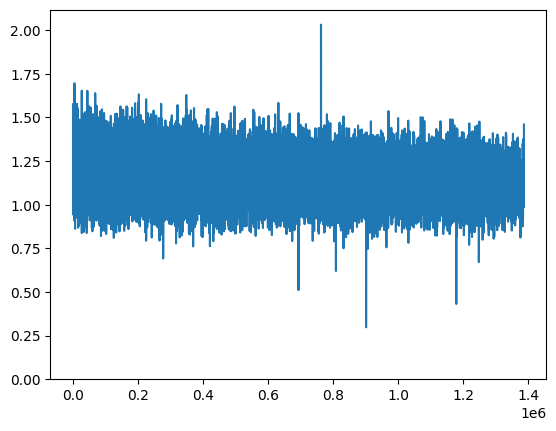

In [25]:
plt.plot(loss_history["step"], loss_history["training_loss"])
plt.ylim(bottom=0.0)
plt.show()

In [26]:
correct_count = 0
random_correct_count = 0
model.eval()

for i, (x, y) in enumerate(validation_draft_dataset):
    if i > 0 and i % 1000 == 0:
        print(f"{i}/{len(validation_draft_dataset)}")

    x = x.to(device)
    y = y.to(device)
    y_logits = model(x)

    pack_card_mask = x[..., -1].bool()
    y = y[pack_card_mask]
    y_logits = y_logits[pack_card_mask]

    if torch.argmax(y_logits) == torch.argmax(y):
        correct_count += 1

    if torch.randint(len(y), size=(1,))[0] == torch.argmax(y):
        random_correct_count += 1

accuracy = 100 * correct_count / len(validation_draft_dataset)
random_accuracy = 100 * random_correct_count / len(validation_draft_dataset)
print(f"Validation Accuracy: {accuracy:.1f}% (random: {random_accuracy:.1f}%)")

1000/17327
2000/17327
3000/17327
4000/17327
5000/17327
6000/17327
7000/17327
8000/17327
9000/17327
10000/17327
11000/17327
12000/17327
13000/17327
14000/17327
15000/17327
16000/17327
17000/17327
Validation Accuracy: 42.1% (random: 18.7%)
